In [1]:
from wve import WaveformVectorEmbedding
import torch
from torch import nn
from datasets import MixedImgDataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Create dataset
dataset = MixedImgDataset(root_dir='./data/MixedImg', transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = WaveformVectorEmbedding(vocab_size=3, num_fft_components=256).to(device)

In [5]:
model.load_state_dict(torch.load('./wve_model.pth', weights_only=True))
model.eval()

WaveformVectorEmbedding(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [6]:
dataset[0][0].shape

torch.Size([3, 256, 256])

In [7]:
# Create a dataloader to get all images
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Get all images in a batch
all_images_bchw, all_labels = next(iter(dataloader))

# Print the shape to confirm
print(f"All images shape: {all_images_bchw.shape}")
print(f"All labels shape: {all_labels.shape}")

# If needed, move to device
all_images_bchw = all_images_bchw.to(device)
all_labels = all_labels.to(device)

All images shape: torch.Size([42, 3, 256, 256])
All labels shape: torch.Size([42])


In [8]:
all_images_bhwc = all_images_bchw.permute(0, 2, 3, 1)  # Convert to BHW(C)

In [9]:
def shap_predict(images_nhwc):
    """
    Predict the class of an image using the model.
    :param image_nhwc: Image in NHWC format
    :return: Predicted class
    """
    # Move to device
    images_nhwc = torch.tensor(images_nhwc).to(device)
    images_nchw = images_nhwc.permute(0, 3, 1, 2)  # Convert to NCHW format
    
    # Forward pass
    with torch.no_grad():
        output = model(images_nchw)
    
    return output

In [10]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [11]:
# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(128, 128)", all_images_bhwc[0].shape)

In [12]:
explainer = shap.Explainer(shap_predict, masker_blur, output_names=['IF', 'Disturbance', 'Normal'])

In [13]:
shap_values = explainer(all_images_bhwc, max_evals=400, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

PartitionExplainer explainer: 43it [00:44,  1.27s/it]                        


In [14]:
def denorm_func(x):
    """
    Denormalize the image tensor.
    :param x: Image tensor
    :return: Denormalized image
    """
    x = x * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return x

In [15]:
shap_values.data = denorm_func(shap_values.data.cpu().numpy()) # (42, 256, 256, 3)
shap_values.values = [val for val in np.transpose(shap_values.values, (4,0,1,2,3))] # shap值热力图

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clip

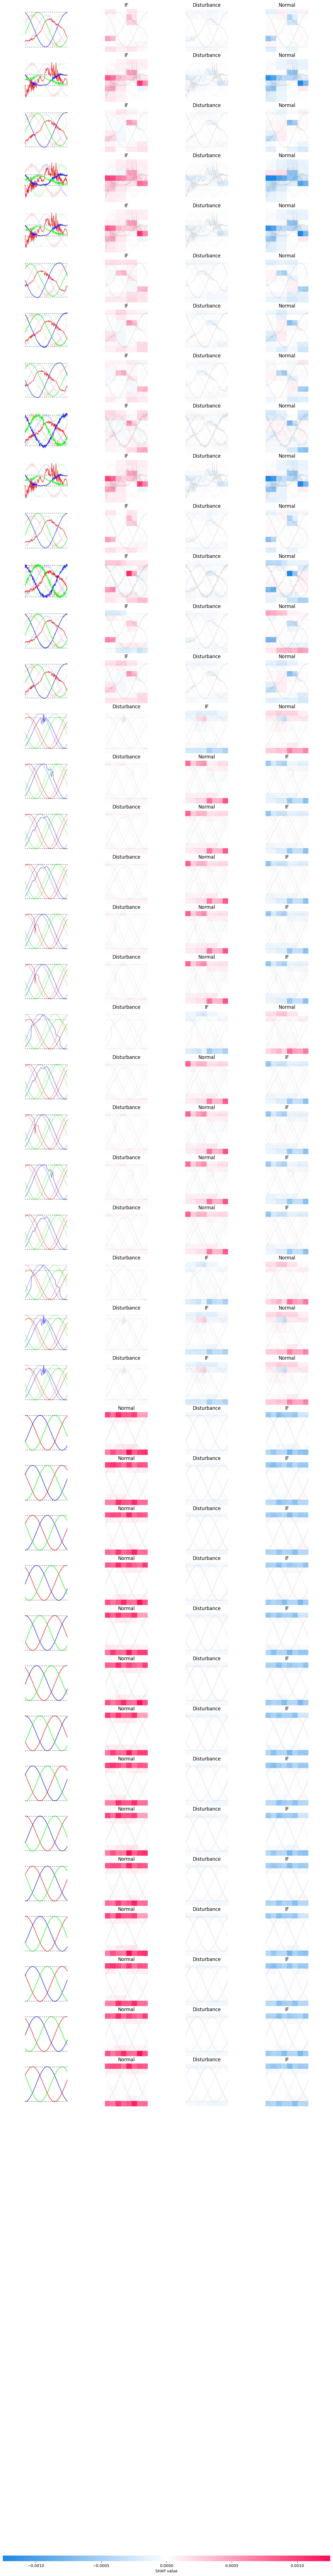

In [16]:
shap.image_plot(shap_values = shap_values.values,
                pixel_values = shap_values.data,
                labels = shap_values.output_names,
                hspace = 'auto',
                show = True)